In [3]:
## PyTorch Transformer
!pip install pytorch_transformers
from pytorch_transformers import RobertaModel, RobertaTokenizer
from pytorch_transformers import RobertaForSequenceClassification, RobertaConfig

  Using cached https://files.pythonhosted.org/packages/a3/b7/d3d18008a67e0b968d1ab93ad444fc05699403fa662f634b2f2c318a508b/pytorch_transformers-1.2.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f5/99/e0808cb947ba10f575839c43e8fafc9cc44e4a7a2c8f79c60db48220a577/sentencepiece-0.1.95-cp37-cp37m-manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/3f/77/cc19511d0fe4672890209ebcbfb9b3f4746572f5a48f7ed2654e7f8c2f29/boto3-1.17.89-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/75/ee/67241dc87f266093c533a2d4d3d69438e57d7a90abb216fa076e7d475d4a/sacremoses-0.0.45-py3-none-any.whl
     |████████████████████████████████| 7.6MB 2.1MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
ERROR: botocore 1.20.89 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
## Check if Cuda is Available
print(torch.cuda.is_available())

True


Get data from this location (https://drive.google.com/drive/folders/11-hyaer3F4kPWljN1HX0B6KhGqO_46f-?usp=sharing)

In [7]:
train = pd.read_csv("/content/drive/MyDrive/Data/train.csv", header = None, names = ["utterance", "slots", "label"])
test = pd.read_csv("/content/drive/MyDrive/Data/test.csv", header = None, names = ["utterance", "slots", "label"])
validation = pd.read_csv("/content/drive/MyDrive/Data/dev.csv", header = None, names = ["utterance", "slots", "label"])
 
#collating the data 
dataset1 = train.append(validation).reset_index(drop=True)
dataset = dataset1.append(test).reset_index(drop=True)
dataset = dataset[["utterance", "label"]]
dataset.head()

,utterance,label
0,BOS Sir I created a new env with python 3.7 bu...,need_help
1,BOS above problem how will it solve ?? EOS,need_help
2,BOS Hello sir is there anyone EOS,Greetings
3,BOS i think canvas login problem was due to br...,great
4,BOS Please provide me with the link to python ...,community_class_link


In [8]:
#Removing BOS, EOS
 
corpus =[]
 
for i in range(len(dataset["utterance"])):
  val = dataset["utterance"][i]
  match =re.sub("[^a-zA-Z]", " ", val)
  #print(match)
  match = re.sub("BOS ", "", match)
  #print(match)
  match = re.sub(" EOS", "", match)
  #print(match)
  match = "".join(match)
  
  corpus.append(match)
 
dataset["utterance"] = pd.DataFrame(corpus)
dataset

,utterance,label
0,Sir I created a new env with python but th...,need_help
1,above problem how will it solve,need_help
2,Hello sir is there anyone,Greetings
3,i think canvas login problem was due to browse...,great
4,Please provide me with the link to python class,community_class_link
...,...,...
4334,x tf Variable xinit tf global variables init...,need_help
4335,partlist type started alt OId ad d a ...,O
4336,Thanks you sir,Thank_you
4337,URIObject uri https api asm skype com v ob...,O


In [9]:
#Labels having occurance<=10
v = dataset["label"].value_counts()[dataset["label"].value_counts()<=10].index
 
#Coverting into list
l = v.tolist()
l

['jupyter_notebook',
 'stats',
 'python_import_error',
 'dashboard_add_recording',
 'image_scrapper',
 'mysql_installation',
 'deployment',
 'review_scrapping',
 'powerbi_installation',
 'youtube_video_availability',
 'tensorflow_installation',
 'anaconda_jnotebook_run',
 'pyspark',
 'github',
 'community_class_link',
 'mongodb_installation',
 'payment_detail',
 'class_registeration_link',
 'canvas_login_problem',
 'pycharm_connection',
 'dashboard_content_view_problem',
 'Plotly_installation',
 'pandas_groupby',
 'previous_recordings',
 'python_conversion_datatype',
 'assignment_numpy',
 'file',
 'doubt_clear_session_recording',
 'assignment_evaluation',
 'colab_help',
 'Dashboard_details',
 'resume_query',
 'postman_url_incorrect_error',
 'powerbi_dataset',
 'gcp_deployment',
 'assignment_link',
 'user_number',
 'pandas_cross_join',
 'string_python',
 'pycharm_interpreter_selection',
 'certificates_enquery',
 'svm_doubt',
 'anaconda_prompt',
 'dashboard_activation',
 'assignment_powe

In [10]:
dataset["label"] = dataset["label"].replace(l,"need_help")
dataset

,utterance,label
0,Sir I created a new env with python but th...,need_help
1,above problem how will it solve,need_help
2,Hello sir is there anyone,Greetings
3,i think canvas login problem was due to browse...,great
4,Please provide me with the link to python class,need_help
...,...,...
4334,x tf Variable xinit tf global variables init...,need_help
4335,partlist type started alt OId ad d a ...,O
4336,Thanks you sir,Thank_you
4337,URIObject uri https api asm skype com v ob...,O


In [11]:
len(set(dataset["label"]))

36

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'No. of utterances per intent')

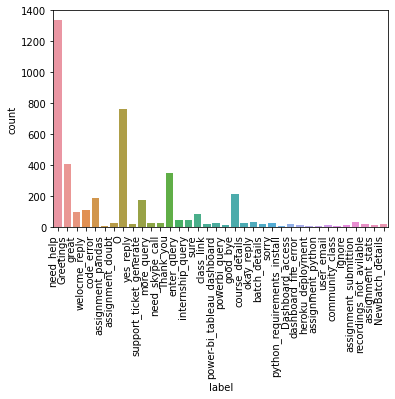

In [12]:
chart = sns.countplot(dataset["label"])
chart.set_xticklabels(chart.get_xticklabels(), rotation =90, horizontalalignment= "right" )
plt.figure(figsize=(300,300))
plt.title("No. of utterances per intent")

In [13]:
dataset["label"].value_counts()

need_help                      1336
O                               763
Greetings                       408
Thank_you                       353
good_bye                        213
code_error                      190
support_ticket_generate         179
welocme_reply                   114
great                            98
sure                             88
enter_query                      48
internship_query                 46
okay_reply                       35
assignment_submittion            33
more_query                       28
sorry                            28
assignment_doubt                 27
course_details                   27
power-bi_tableau_dashboard       26
need_skype_call                  26
batch_details                    25
recordings_not_avilable          24
Dashboard_access                 23
yes_reply                        23
class_link                       22
NewBatch_details                 21
user_email                       18
powerbi_query               

In [14]:
label_to_ix = {}
for label in dataset.label:
    for word in label.split():
        if word not in label_to_ix:
            label_to_ix[word]=len(label_to_ix)
label_to_ix

{'Dashboard_access': 25,
 'Greetings': 1,
 'NewBatch_details': 35,
 'O': 7,
 'Thank_you': 12,
 'assignment_doubt': 6,
 'assignment_pandas': 5,
 'assignment_python': 28,
 'assignment_stats': 34,
 'assignment_submittion': 32,
 'batch_details': 22,
 'class_link': 16,
 'code_error': 4,
 'community_class': 30,
 'course_details': 20,
 'dashboard_file_error': 26,
 'enter_query': 13,
 'good_bye': 19,
 'great': 2,
 'heroku_deployment': 27,
 'ignore': 31,
 'internship_query': 14,
 'more_query': 10,
 'need_help': 0,
 'need_skype_call': 11,
 'okay_reply': 21,
 'power-bi_tableau_dashboard': 17,
 'powerbi_query': 18,
 'python_requirements_install': 24,
 'recordings_not_avilable': 33,
 'sorry': 23,
 'support_ticket_generate': 9,
 'sure': 15,
 'user_email': 29,
 'welocme_reply': 3,
 'yes_reply': 8}

In [15]:
config = RobertaConfig.from_pretrained('roberta-base')
config.num_labels = len(list(label_to_ix.values()))
config

100%|██████████| 481/481 [00:00<00:00, 120719.26B/s]


{
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 36,
  "output_attentions": false,
  "output_hidden_states": false,
  "pad_token_id": 1,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "vocab_size": 50265
}

In [ ]:
label_to_ix = {}
for label in dataset.label:
    for word in label.split():
        if word not in label_to_ix:
            label_to_ix[word]=len(label_to_ix)
label_to_ixlabel_to_ix = {}
for label in dataset.label:
    for word in label.split():
        if word not in label_to_ix:
            label_to_ix[word]=len(label_to_ix)
label_to_ix

{'Dashboard_access': 25,
 'Greetings': 1,
 'NewBatch_details': 35,
 'O': 7,
 'Thank_you': 12,
 'assignment_doubt': 6,
 'assignment_pandas': 5,
 'assignment_python': 28,
 'assignment_stats': 34,
 'assignment_submittion': 32,
 'batch_details': 22,
 'class_link': 16,
 'code_error': 4,
 'community_class': 30,
 'course_details': 20,
 'dashboard_file_error': 26,
 'enter_query': 13,
 'good_bye': 19,
 'great': 2,
 'heroku_deployment': 27,
 'ignore': 31,
 'internship_query': 14,
 'more_query': 10,
 'need_help': 0,
 'need_skype_call': 11,
 'okay_reply': 21,
 'power-bi_tableau_dashboard': 17,
 'powerbi_query': 18,
 'python_requirements_install': 24,
 'recordings_not_avilable': 33,
 'sorry': 23,
 'support_ticket_generate': 9,
 'sure': 15,
 'user_email': 29,
 'welocme_reply': 3,
 'yes_reply': 8}

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification(config)

100%|██████████| 456318/456318 [00:00<00:00, 1346028.25B/s]


In [ ]:
def prepare_features(seq_1, max_seq_length = 300, 
             zero_pad = False, include_CLS_token = True, include_SEP_token = True):
    ## Tokenzine Input
    tokens_a = tokenizer.tokenize(seq_1)
 
    ## Truncate
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0:(max_seq_length - 2)]
    ## Initialize Tokens
    tokens = []
    if include_CLS_token:
        tokens.append(tokenizer.cls_token)
    ## Add Tokens and separators
    for token in tokens_a:
        tokens.append(token)
 
    if include_SEP_token:
        tokens.append(tokenizer.sep_token)
 
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    ## Input Mask 
    input_mask = [1] * len(input_ids)
    ## Zero-pad sequence length
    if zero_pad:
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
    return torch.tensor(input_ids).unsqueeze(0), input_mask

In [ ]:
msg = "My dog is cute!"
prepare_features(msg)

(tensor([[    0,  1308,  2335,    16, 11962,   328,     2]]),
 [1, 1, 1, 1, 1, 1, 1])

In [ ]:
class Intents(Dataset):
    def __init__(self, dataframe):
        self.len = len(dataframe)
        self.data = dataframe
        
    def __getitem__(self, index):
        utterance = self.data.utterance[index]
        label = self.data.label[index]
        X, _  = prepare_features(utterance)
        y = label_to_ix[self.data.label[index]]
        return X, y
    
    def __len__(self):
        return self.len

In [ ]:
train_size = 0.8
train_dataset=dataset.sample(frac=train_size,random_state=200).reset_index(drop=True)
test_dataset=dataset.drop(train_dataset.index).reset_index(drop=True)

In [ ]:
#Unseen labels
train_label = set(train_dataset["label"])
print(len(train_label))
test_label = set(test_dataset["label"])
print(len(test_label))
Common_labels = train_label.intersection(test_label)
len(Common_labels)

36
36


36

len(train_label)=36  and len(test_label)=36 and intersection of both of them is also 36, it means 0 unseen classes for training dataset.


In [ ]:
print("FULL Dataset: {}".format(dataset.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

FULL Dataset: (4339, 2)
TRAIN Dataset: (3471, 2)
TEST Dataset: (868, 2)


In [ ]:
training_set = Intents(train_dataset)
testing_set = Intents(test_dataset)

In [ ]:
training_set.__getitem__(0)[0].shape

torch.Size([1, 20])

In [ ]:
model(training_set.__getitem__(0)[0])

(tensor([[-0.1492, -0.3322, -0.2174, -0.3797, -0.0961, -0.2135,  0.5502, -0.1895,
          -0.1268, -0.0515,  0.7273,  0.4709, -0.1928,  0.0808, -0.1646, -0.5350,
           0.0370, -0.3408,  0.0519,  0.8792,  0.1150,  0.0660,  0.1295, -0.1906,
           0.2554, -0.5508,  0.1953, -0.1980,  0.0121, -0.3441, -0.0547,  0.2220,
          -0.0098,  0.2128, -0.6194,  0.1333]], grad_fn=<AddmmBackward>),)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.cuda()

In [ ]:
# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 1}

In [ ]:
training_loader = DataLoader(training_set, **params)
testing_loader = DataLoader(testing_set, **params)

In [ ]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-05
optimizer = optim.Adam(params =  model.parameters(), lr=learning_rate)

In [ ]:
## Test Forward Pass
inp = training_set.__getitem__(0)[0].cuda()
output = model(inp)[0]
torch.max(output.data, 1)

torch.return_types.max(values=tensor([0.4766], device='cuda:0'), indices=tensor([24], device='cuda:0'))

In [ ]:
max_epochs = 25
model = model.train()
for epoch in tqdm_notebook(range(max_epochs)):
    print("EPOCH -- {}".format(epoch))
    for i, (sent, label) in enumerate(training_loader):
        optimizer.zero_grad()
        sent = sent.squeeze(0)
        if torch.cuda.is_available():
          sent = sent.cuda()
          label = label.cuda()
        output = model.forward(sent)[0]
        _, predicted = torch.max(output, 1)
        
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
        if i%100 == 0:
            correct = 0
            total = 0
            for sent, label in testing_loader:
                sent = sent.squeeze(0)
                if torch.cuda.is_available():
                  sent = sent.cuda()
                  label = label.cuda()
                output = model.forward(sent)[0]
                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted.cpu() == label.cpu()).sum()
            accuracy = 100.00 * correct.numpy() / total
            print('Iteration: {}. Loss: {}. Accuracy: {}%'.format(i, loss.item(), accuracy))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


EPOCH -- 0
Iteration: 0. Loss: 3.5499157905578613. Accuracy: 29.262672811059907%
Iteration: 100. Loss: 3.475480318069458. Accuracy: 30.4147465437788%
Iteration: 200. Loss: 2.7712323665618896. Accuracy: 44.354838709677416%
Iteration: 300. Loss: 0.792609691619873. Accuracy: 45.6221198156682%
Iteration: 400. Loss: 0.22209835052490234. Accuracy: 48.04147465437788%
Iteration: 500. Loss: 1.3108340501785278. Accuracy: 50.806451612903224%
Iteration: 600. Loss: 3.633397102355957. Accuracy: 48.38709677419355%
Iteration: 700. Loss: 3.937486410140991. Accuracy: 50.576036866359445%
Iteration: 800. Loss: 0.9162030220031738. Accuracy: 53.80184331797235%
Iteration: 900. Loss: 1.6955093145370483. Accuracy: 54.03225806451613%
Iteration: 1000. Loss: 5.260263919830322. Accuracy: 54.83870967741935%
Iteration: 1100. Loss: 0.8074461221694946. Accuracy: 54.03225806451613%
Iteration: 1200. Loss: 0.45984867215156555. Accuracy: 57.48847926267281%
Iteration: 1300. Loss: 0.7814744710922241. Accuracy: 55.5299539170

In [ ]:
PATH= '/content/drive/MyDrive/Roberta.pt' 

In [ ]:


# Save
torch.save(model, PATH)



In [ ]:
# Load
model = torch.load(PATH,map_location='cpu')
# model.eval()

In [ ]:
def get_reply(msg):
  model.eval()
  input_msg, _ = prepare_features(msg)
  if torch.cuda.is_available():
    input_msg = input_msg.cuda()
  output = model(input_msg)[0]
  _, pred_label = torch.max(output.data, 1)
  prediction=list(label_to_ix.keys())[pred_label]
  return prediction
